### Libs importing and drive mounting

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt

### Data loading and preprocessing

In [42]:
# Load dataset from Google Drive
csv_path = 'variant1-mushrooms.csv'  
data = pd.read_csv(csv_path)

# Drop the ID column and separate features and target
X = data.drop(columns=['class']).values  # Drop target columns
y = data['class'].values  # Extract the target column

# Standardize the feature values for better training performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Training features as a tensor
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Training labels as a tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Testing features as a tensor
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)  # Testing labels as a tensor

### Model and hyperparameters definition

In [43]:
# Define a simple Multi-Layer Perceptron (MLP) for binary classification
class BinaryClassificationMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BinaryClassificationMLP, self).__init__()
        self.hidden_layer = nn.Linear(input_size, hidden_size)  # First layer (input to hidden)
        self.output_layer = nn.Linear(hidden_size, output_size)  # Second layer (hidden to output)
        self.relu = nn.ReLU()  # ReLU activation function for hidden layer
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for output layer

    def forward(self, x):
        x = self.hidden_layer(x)  # Linear transformation for the hidden layer
        x = self.relu(x)  # Apply ReLU activation
        x = self.output_layer(x)  # Linear transformation for the output layer
        x = self.sigmoid(x)  # Apply sigmoid activation for binary classification
        return x

# Set hyperparameters
input_size = X_train.shape[1]  # Number of features in the dataset
hidden_size = 32  # Number of neurons in the hidden layer
output_size = 1  # Binary classification output
learning_rate = 0.05  # Learning rate for the optimizer
num_epochs = 300  # Number of epochs to train the model

### Train loop

In [44]:
# Initialize the model, loss function, and optimizer
model = BinaryClassificationMLP(input_size, hidden_size, output_size)  # Create the model instance
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer

# Metrics and logging
losses = []
accuracies = []

# Training loop
model.train()  # Set the model to training mode
for epoch in range(num_epochs):
    # Forward pass: compute predictions
    outputs = model(X_train_tensor)

    # Compute the loss between predictions and actual labels
    loss = criterion(outputs, y_train_tensor)
    losses.append(loss.item())

    # Convert predictions to binary values (0 or 1)
    predictions = (outputs.detach().numpy() > 0.5).astype(int)
    y_train_numpy = y_train_tensor.numpy()
    accuracy = accuracy_score(y_train_numpy, predictions)
    accuracies.append(accuracy)

    # Backward pass: compute gradients and update weights
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()  # Compute gradients
    optimizer.step()  # Update weights based on gradients

    # Print loss and accuracy every 100 epochs for monitoring
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy * 100:.2f}%')

Epoch [10/300], Loss: 0.5882, Accuracy: 69.00%
Epoch [20/300], Loss: 0.5389, Accuracy: 71.74%
Epoch [30/300], Loss: 0.4904, Accuracy: 75.36%
Epoch [40/300], Loss: 0.4472, Accuracy: 79.33%
Epoch [50/300], Loss: 0.4160, Accuracy: 80.99%
Epoch [60/300], Loss: 0.3866, Accuracy: 82.48%
Epoch [70/300], Loss: 0.3667, Accuracy: 83.66%
Epoch [80/300], Loss: 0.3483, Accuracy: 84.92%
Epoch [90/300], Loss: 0.3393, Accuracy: 85.74%
Epoch [100/300], Loss: 0.3239, Accuracy: 86.55%
Epoch [110/300], Loss: 0.3125, Accuracy: 87.14%
Epoch [120/300], Loss: 0.3054, Accuracy: 87.68%
Epoch [130/300], Loss: 0.3027, Accuracy: 87.46%
Epoch [140/300], Loss: 0.2995, Accuracy: 87.24%
Epoch [150/300], Loss: 0.2881, Accuracy: 88.63%
Epoch [160/300], Loss: 0.2818, Accuracy: 88.75%
Epoch [170/300], Loss: 0.2775, Accuracy: 88.91%
Epoch [180/300], Loss: 0.2766, Accuracy: 89.16%
Epoch [190/300], Loss: 0.2728, Accuracy: 89.02%
Epoch [200/300], Loss: 0.2682, Accuracy: 89.43%
Epoch [210/300], Loss: 0.2645, Accuracy: 89.45%
E

### Validation

Test Loss: 0.2420
Test Accuracy: 90.43%
              precision    recall  f1-score   support

     Class 0       0.90      0.89      0.89      4909
     Class 1       0.91      0.92      0.91      5898

    accuracy                           0.90     10807
   macro avg       0.90      0.90      0.90     10807
weighted avg       0.90      0.90      0.90     10807



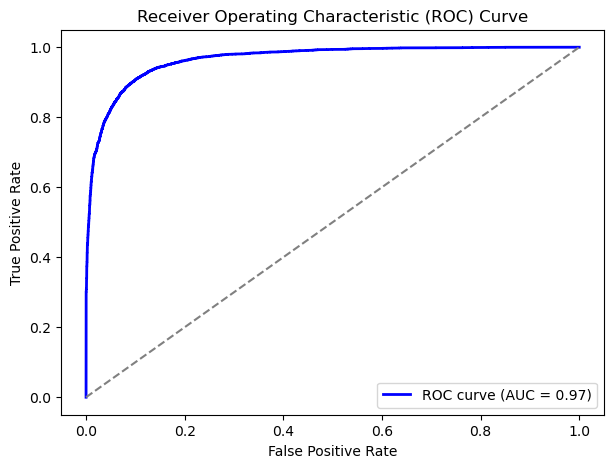

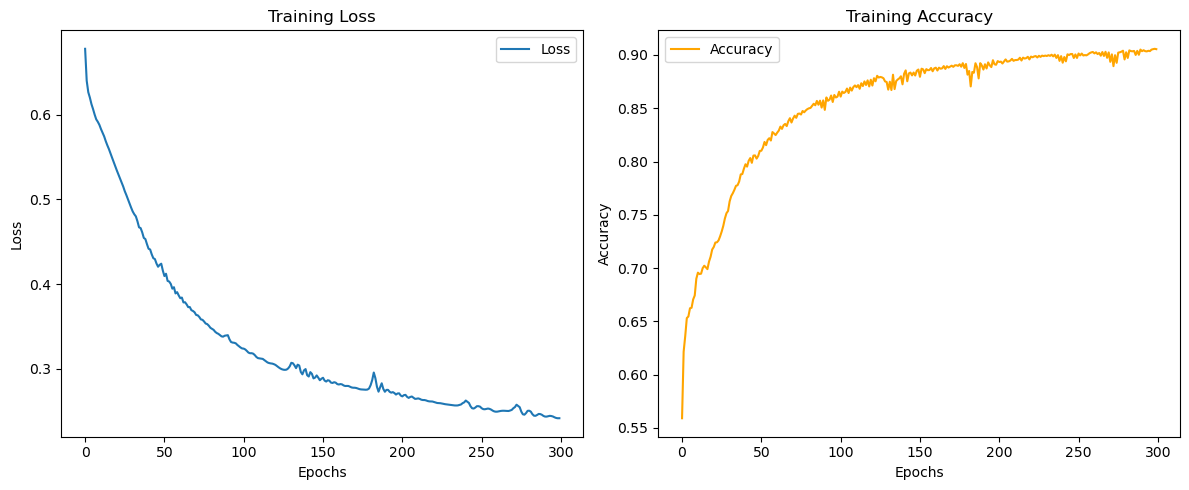

In [45]:
# Evaluate the model on the test dataset
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for evaluation
    outputs = model(X_test_tensor)  # Compute predictions
    test_loss = criterion(outputs, y_test_tensor)  # Compute the loss for the test set

    # Convert predictions to binary values (0 or 1)
    test_predictions = (outputs.numpy() > 0.5).astype(int)
    y_test_numpy = y_test_tensor.numpy()

    # Compute metrics
    test_accuracy = accuracy_score(y_test_numpy, test_predictions)

    print(f'Test Loss: {test_loss.item():.4f}')
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Generate a classification report
    print(classification_report(y_test_numpy, test_predictions, target_names=["Class 0", "Class 1"]))

    # Compute ROC curve and AUC
    y_probabilities = outputs.numpy()  # Get predicted probabilities
    fpr, tpr, _ = roc_curve(y_test_numpy, y_probabilities)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random guess)
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), accuracies, label='Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Висновок
* У ході виконання лабораторної роботи було порівнено PyTorch та Numpy. В PyTorch використовуються готові бібліотеки та функції, а в Numpy всі розрахунки та функції пишуться вручну.

| Параметри                      | Train Acc | Test Acc   | Train Loss | Test Loss | Precision   | Recall      | F1-score    |
| ------------------------------ | --------- | ---------- | ---------- | --------- | ----------- | ----------- | ----------- |
| 16, lr=0.01, 250 ep            | 80.47%    | 96.49%     | 0.4197     | 0.1785    | 0.79 / 0.82 | 0.78 / 0.83 | 0.79 / 0.82 | 
| 8, lr=0.001, 100 ep            | 62.87%    | 80.65%     | 0.6469     | 0.4186    | 0.63 / 0.63 | 0.46 / 0.77 | 0.53 / 0.70 | 
| 32, lr=0.05, 300 ep            | 90.55%    | 90.43%     | 0.2415     | 0.2420    | 0.90 / 0.91 | 0.89 / 0.92 | 0.89 / 0.91 | 

* Після проведення тестування різних параметрів отримали різні результати, занесли їх в таблицю. Найкращими параметрами виявились - 32 нейрони в вищому рівні, коефіцієнт швидкості навчання 0,05 , кількість епох 300 та 10 батчі. Параметри дуже впливають на вихідний результат. Чим більший крок навчання, модель недонавчається, а якщо занадто великий, то перенавчання моделі.   